In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Baseline Model

In [2]:
df = pd.read_csv('../data/processed/dataset.csv').copy()
df.head()


,Unnamed: 0,sales_agent,account,opportunity_status,manager,regional_office,sector,revenue,office_location,product,series,sales_price,duration,won,close_value
0,0,moses frase,cancity,completed,dustin brinkmann,central,retail,718.62,united states,gtx plus basic,gtx,1096.0,132.0,1,1054.0
1,1,darcel schlecht,isdom,completed,melvin marxen,central,medical,3178.24,united states,gtxpro,NaN,NaN,137.0,1,4514.0
2,2,darcel schlecht,cancity,completed,melvin marxen,central,retail,718.62,united states,mg special,mg,55.0,133.0,1,50.0
3,3,moses frase,codehow,completed,dustin brinkmann,central,software,2714.90,united states,gtx basic,gtx,550.0,135.0,1,588.0
4,4,zane levy,hatfan,completed,summer sewald,west,services,792.46,united states,gtx basic,gtx,550.0,128.0,1,517.0


X : Client details (account, sector, revenue, office_location) + 
     Sale details (sales_agent, product, deal_stage, duration , sector)

y: close_value

In [3]:
df.columns


Index(['Unnamed: 0', 'sales_agent', 'account', 'opportunity_status', 'manager',
       'regional_office', 'sector', 'revenue', 'office_location', 'product',
       'series', 'sales_price', 'duration', 'won', 'close_value'],
      dtype='object')

## Data Preparation

### Duplicated

In [4]:
df.duplicated().sum()

np.int64(0)

### Missing Values

In [5]:
df.isnull().sum().sort_values(ascending=False)/ len(df)

duration              0.237386
close_value           0.237386
series                0.168182
sales_price           0.168182
account               0.161932
sector                0.161932
revenue               0.161932
office_location       0.161932
Unnamed: 0            0.000000
sales_agent           0.000000
opportunity_status    0.000000
manager               0.000000
regional_office       0.000000
product               0.000000
won                   0.000000
dtype: float64

In [6]:
df = df.dropna(subset=['close_value']).reset_index(drop=True)

In [7]:
X = df.drop(columns=['Unnamed: 0'])
y = df['close_value']

In [8]:
num_feat = ['revenue','sales_price', 'won', 'duration']
cat_feat = ['account', 'sector', 'office_location','sales_agent', 'product','opportunity_status', 'manager','regional_office', 'series']


In [9]:
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

imputer_num.fit(df[num_feat])
df[num_feat] = imputer_num.transform(df[num_feat])

imputer_cat.fit(df[cat_feat])
df[cat_feat] = imputer_cat.transform(df[cat_feat])

print(imputer_num.statistics_)
print(imputer_cat.statistics_)

[2.52021271e+03 1.87639522e+03 1.00000000e+00 4.79853971e+01]
['hottechi' 'retail' 'united states' 'darcel schlecht' 'gtx basic'
 'completed' 'melvin marxen' 'central' 'gtx']


In [10]:
df.isnull().sum().sort_values(ascending=False)/ len(df)

Unnamed: 0            0.0
sales_agent           0.0
account               0.0
opportunity_status    0.0
manager               0.0
regional_office       0.0
sector                0.0
revenue               0.0
office_location       0.0
product               0.0
series                0.0
sales_price           0.0
duration              0.0
won                   0.0
close_value           0.0
dtype: float64

## Outliers

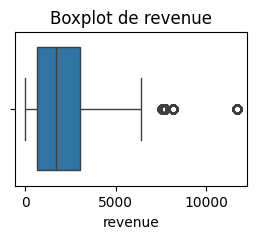

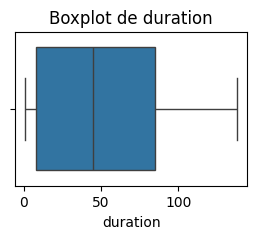

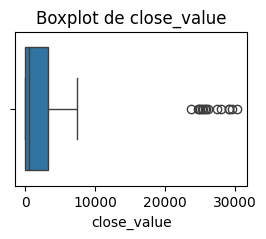

In [11]:
for col in ['revenue', 'duration', 'close_value']:
    plt.figure(figsize=(3, 2))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot de {col}')
    plt.show()

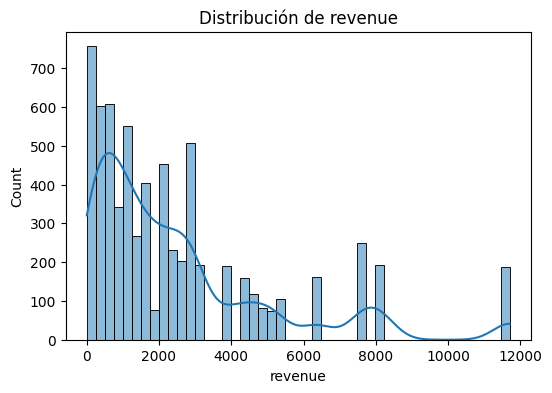

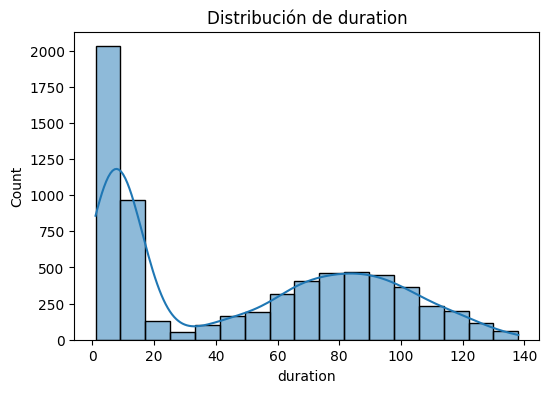

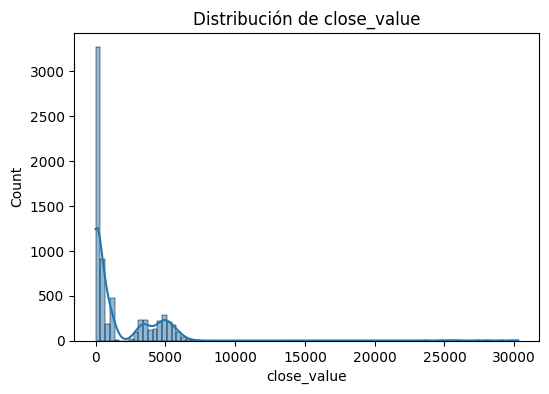

In [12]:
for col in ['revenue', 'duration', 'close_value']:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()


• Decision: I won't remove outliers because they make sense from a business perspective

• Decision: Because features like revenue and close_value contain true extreme values (not noise), and the distribution is highly skewed.

• Decision: I won't use StandardScaler because there is skewness and potential outliers


In [14]:
correlations = df.corr(numeric_only=True)['close_value'].sort_values(ascending=False)
print(correlations.head(10))

close_value    1.000000
sales_price    0.606111
duration       0.049888
revenue        0.028136
Unnamed: 0    -0.023758
won                 NaN
Name: close_value, dtype: float64


## Feature Scaling


In [16]:
scaler = RobustScaler()

scaler.fit(df[num_feat])
df[num_feat] = scaler.transform(df[num_feat])


In [17]:
df.head()

,Unnamed: 0,sales_agent,account,opportunity_status,manager,regional_office,sector,revenue,office_location,product,series,sales_price,duration,won,close_value
0,0,moses frase,cancity,completed,dustin brinkmann,central,retail,-0.411540,united states,gtx plus basic,gtx,0.000000,1.129870,0.0,1054.0
1,1,darcel schlecht,isdom,completed,melvin marxen,central,medical,0.621792,united states,gtxpro,gtx,0.274497,1.194805,0.0,4514.0
2,2,darcel schlecht,cancity,completed,melvin marxen,central,retail,-0.411540,united states,mg special,mg,-0.366163,1.142857,0.0,50.0
3,3,moses frase,codehow,completed,dustin brinkmann,central,software,0.427135,united states,gtx basic,gtx,-0.192051,1.168831,0.0,588.0
4,4,zane levy,hatfan,completed,summer sewald,west,services,-0.380518,united states,gtx basic,gtx,-0.192051,1.077922,0.0,517.0


## Balancing

## Encoding


In [18]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

ohe.fit(df[cat_feat])

encoded_cat = ohe.transform(df[cat_feat])

encoded_columns = ohe.get_feature_names_out(cat_feat)

df_encoded_cat = pd.DataFrame(encoded_cat, columns=encoded_columns, index=df.index)

df_ohe = pd.concat([df.drop(columns=cat_feat), df_encoded_cat], axis=1)

In [19]:
correlations = df_ohe.corr(numeric_only=True)['close_value'].sort_values(ascending=False)
print(correlations.head(10))


close_value                    1.000000
sales_price                    0.606111
product_gtx plus pro           0.310480
product_gtxpro                 0.307140
series_gtx                     0.110048
product_mg advanced            0.104734
sales_agent_darcel schlecht    0.076769
manager_rocco neubert          0.051993
duration                       0.049888
sales_agent_elease gluck       0.047944
Name: close_value, dtype: float64


In [20]:
df_ohe.shape


(6711, 157)

In [21]:
df_ohe.columns

Index(['Unnamed: 0', 'revenue', 'sales_price', 'duration', 'won',
       'close_value', 'account_betasoloin', 'account_betatech',
       'account_bioholding', 'account_bioplex',
       ...
       'product_mg special', 'manager_celia rouche',
       'manager_dustin brinkmann', 'manager_melvin marxen',
       'manager_rocco neubert', 'manager_summer sewald',
       'regional_office_east', 'regional_office_west', 'series_gtx',
       'series_mg'],
      dtype='object', length=157)

In [22]:
ohe.categories_


[array(['acme corporation', 'betasoloin', 'betatech', 'bioholding',
        'bioplex', 'blackzim', 'bluth company', 'bubba gump', 'cancity',
        'cheers', 'codehow', 'condax', 'conecom', 'dalttechnology',
        'dambase', 'domzoom', 'doncon', 'donquadtech', 'dontechi',
        'donware', 'fasehatice', 'faxquote', 'finhigh', 'finjob',
        'funholding', 'ganjaflex', 'gekko & co',
        'genco pura olive oil company', 'globex corporation', 'gogozoom',
        'golddex', 'goodsilron', 'green-plus', 'groovestreet', 'hatfan',
        'hottechi', 'initech', 'inity', 'isdom', 'iselectrics', 'j-texon',
        'kan-code', 'kinnamplus', 'konex', 'konmatfix', 'labdrill',
        'lexiqvolax', 'massive dynamic', 'mathtouch', 'nam-zim', 'newex',
        'ontomedia', 'opentech', 'plexzap', 'plusstrip', 'plussunin',
        'rangreen', 'rantouch', 'ron-tech', 'rundofase', 'scotfind',
        'scottech', 'silis', 'singletechno', 'sonron', 'stanredtax',
        'statholdings', 'streethex', 

## Model


In [23]:
X_ohe = df_ohe.drop(columns=['Unnamed: 0','close_value'])
y = df_ohe['close_value']

### Linear Regression Model

In [24]:
model_LR = LinearRegression()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.3, random_state=42)
cv_results_LR = cross_validate(model_LR, X_train, y_train, cv=5)
cv_results_LR['test_score'].mean()

np.float64(0.44958901573270466)

In [26]:
model_LR.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [27]:
y_pred = model_LR.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))


R2 Score: 0.38665612018832163
MAE: 1166.3326991775884
RMSE: 3184560.780826366


### Random Forest Regressor Model

In [28]:
model_RFR = RandomForestRegressor(random_state=42)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.3, random_state=42)
cv_results_LR = cross_validate(model_RFR, X_train, y_train, cv=5)
cv_results_LR['test_score'].mean()

np.float64(0.3853464489327548)

In [30]:
model_RFR.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
y_pred_RFR = model_RFR.predict(X_test)


In [33]:
print("R2 Score:", r2_score(y_test, y_pred_RFR))
print("MAE:", mean_absolute_error(y_test, y_pred_RFR))
print("RMSE:", mean_squared_error(y_test, y_pred_RFR))

R2 Score: 0.35371563997772604
MAE: 1100.6997005899184
RMSE: 3355592.0160486996


### Gradient Boosting Regressor

In [34]:
model_GBR = GradientBoostingRegressor(random_state=42)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.3, random_state=42)
cv_results_GBR = cross_validate(model_GBR, X_train, y_train, cv=5)
cv_results_GBR['test_score'].mean()

np.float64(0.4421111197097839)

In [40]:
model_GBR.fit(X_train, y_train)

y_pred_GBR = model_GBR.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred_GBR))
print("MAE:", mean_absolute_error(y_test, y_pred_GBR))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_GBR)))


R2 Score: 0.40240106312970014
MAE: 1115.4818254454212
RMSE: 1761.4797756239122


Summary 

| Model                     | CV R² (Train) | Test R² | Test MAE | Test RMSE |
|--------------------------|---------------|---------|----------|-----------|
| **Linear Regression**     | 0.45          | 0.39    | 1166.33  | 1783.44   |
| **Random Forest Regressor** | 0.39        | 0.35    | **1100.70** | 1832.49   |
| **Gradient Boosting Regressor** | **0.44** | **0.40**| 1115.48  | **1761.48** |

 **Linear Regression** provides a solid baseline with a CV R² of 0.45 but shows the highest MAE among all models.
 
 **Random Forest Regressor** achieves the **lowest MAE**, but its lower R² suggests it may not generalize as well as the other models.
 
 **Gradient Boosting Regressor** shows the **best overall performance**, with strong R² scores in both CV and test sets, and the lowest RMSE, making it the most promising model so far.